# Neural network-based model for the identification of Bladder Cancers subtypes

## Transduction method

### Pretreatment of the data:
- necessary libraries imports
- dataframe definition
- dataframe sorting and cleaning

In [1]:
import os
import torch
os.environ['TORCH'] = torch.__version__
from torch_geometric.data import Data
from torch_geometric.nn import GATv2Conv

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

Dataframe_Labels = pd.read_csv("../../BLCA_DATA/Workspace/labels_str.csv")
Dataframe_link = pd.read_csv("../../BLCA_DATA/Workspace/patient_norm.csv")
Dataframe_node= pd.read_csv("../../BLCA_DATA/Workspace/node_embedding.csv")

Dataframe_Labels['class_int'], uniques = pd.factorize(Dataframe_Labels['class'])
Dataframe_Labels

,Patient,class,class_int
0,TCGA-2F-A9KO,LumP,0
1,TCGA-2F-A9KP,LumP,0
2,TCGA-2F-A9KQ,LumP,0
3,TCGA-2F-A9KR,Ba/Sq,1
4,TCGA-2F-A9KT,Ba/Sq,1
...,...,...,...
399,TCGA-ZF-AA56,Ba/Sq,1
400,TCGA-ZF-AA58,Ba/Sq,1
401,TCGA-ZF-AA5H,Ba/Sq,1
402,TCGA-ZF-AA5N,LumP,0


class
Ba/Sq          153
LumP           127
LumU            53
Stroma-rich     45
LumNS           20
NE-like          6
Name: count, dtype: int64


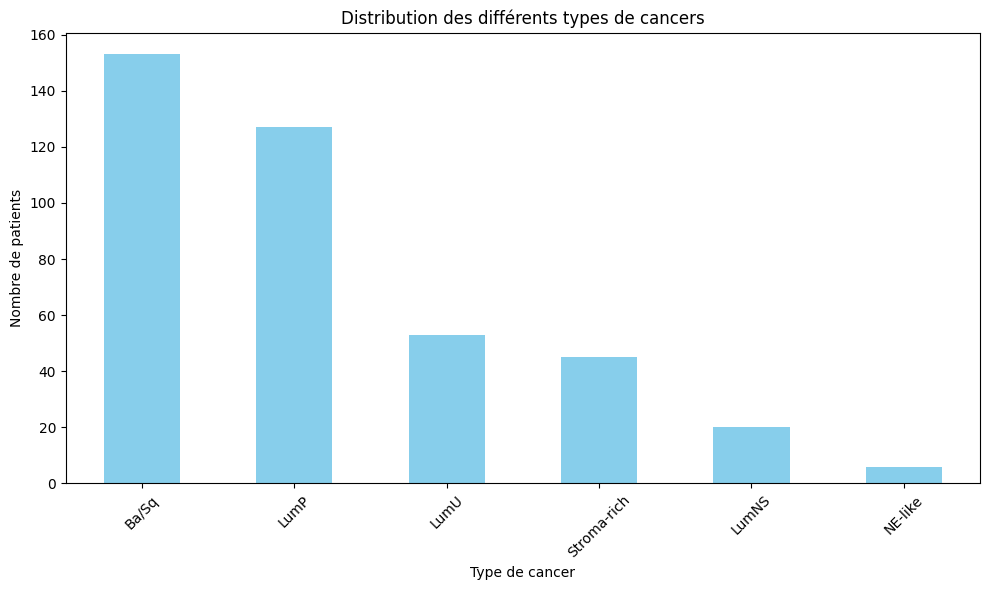

In [2]:
cancer_distribution = Dataframe_Labels['class'].value_counts()

# Plot the distribution of the classes
print(cancer_distribution)

plt.figure(figsize=(10, 6))
cancer_distribution.plot(kind='bar', color='skyblue')
plt.title('Distribution des différents types de cancers')
plt.xlabel('Type de cancer')
plt.ylabel('Nombre de patients')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

We choose to delete the patient having the last two cancers due to a low number fo data.

In [3]:
# Dataframe definition
Dataframe_Labels = pd.read_csv("../../BLCA_DATA/Workspace/labels_str.csv")          # Contains the labels of each patient (=cancer)
Dataframe_link = pd.read_csv("../../BLCA_DATA/Workspace/patient_norm.csv")          # Contains the clinic datas of each patient (will be used for link initialization)
Dataframe_node = pd.read_csv("../../BLCA_DATA/Workspace/node_embedding.csv")        # Contains the omic datas of each patient (will be used for node initialization)

# Adding a column to associate each class to a integer
Dataframe_Labels['class_int'], uniques = pd.factorize(Dataframe_Labels['class'])

# Filtering the dataframe to get rid of the two last classes (not enough datas)
Dataframe_Labels = Dataframe_Labels[~Dataframe_Labels['class_int'].isin([4, 5])]

patients_to_keep = Dataframe_Labels['Patient'].unique()
Dataframe_link = Dataframe_link[Dataframe_link['Patient'].isin(patients_to_keep)]
Dataframe_node = Dataframe_node[Dataframe_node['Patient'].isin(patients_to_keep)]

# Reset the labels to get clean Dataframes
Dataframe_Labels = Dataframe_Labels.reset_index(drop=True)
Dataframe_link = Dataframe_link.reset_index(drop=True)
Dataframe_node = Dataframe_node.reset_index(drop=True)


### Graph initialization (weight, nodes and links)

Each weight is defined following this formula :
$$\mu = \text{mean of the number of patient victim of a type of cancer}$$
$$n_i = \text{number of victim of each cancer}$$
$$w_i = \text{weight of the ith class}$$

$$w_i = \frac{\frac{\mu}{n_i}}{\sum \left( \frac{\mu}{n_j} \right)}$$

In [4]:
classes_dict = {0: 'LumP', 
                1: 'Ba/Sq', 
                2: 'LumU', 
                3: 'Stroma-rich'
}

def count_classes_weights(tensor):
    array = tensor.numpy()
    classes_tab = { 0: 0, 
                    1: 0,
                    2: 0, 
                    3: 0
    }
    for i in array:
        classes_tab[i]+=1

    mean_nb_classes = 0
    for i in classes_tab:
        mean_nb_classes += i
    mean_nb_classes *= 1/len(classes_tab)
    
    # normalize the weights
    weight_sum = 0
    for i in range(len(classes_tab)):
        if classes_tab[i] != 0:
            weight_sum += mean_nb_classes / classes_tab[i]
    alpha = 1 / weight_sum

    weight_dict = {}
    used_classes = []
    for i in range(len(classes_tab)):
        if classes_tab[i] != 0:
            weight_dict[i] = alpha * (mean_nb_classes / classes_tab[i]) *50
            used_classes.append(classes_dict[i])

    return used_classes, weight_dict

Nodes and links initialization :

In [5]:
from sklearn.model_selection import train_test_split

node_features = Dataframe_node.drop(columns=['Patient']).values
node_features = torch.tensor(node_features, dtype=torch.float)

train_val_indices = [i for i in range(node_features.shape[0])]
_, test_indices = train_test_split(
    range(len(node_features)), 
    test_size=0.2, 
    random_state=12345
)

x_train = node_features[train_val_indices]
x_test = node_features[test_indices]

patient_similarity = cosine_similarity(Dataframe_link.iloc[:, 1:])
similarity_threshold = 0.5  # Exemple de seuil de similarité

# Calculate the edges and attention ridges for training
edge_index_for_training = []
edge_attr_for_training = []
re_indexed_i = 0
re_indexed_j = 0
for i in range(len(train_val_indices)):
    for j in range(i+1, len(train_val_indices)):
        if patient_similarity[i, j] > similarity_threshold:
            edge_index_for_training.append([re_indexed_i, re_indexed_j])
            edge_attr_for_training.append((patient_similarity[i, j] - similarity_threshold)/(1 - similarity_threshold))
        re_indexed_j +=1
    re_indexed_i +=1
    re_indexed_j = 0

# Calculate the edges and attention ridges for testing
edge_index_for_testing = []
edge_attr_for_testing = []
re_indexed_i = 0
re_indexed_j = 0
for i in test_indices:
    for j in test_indices:
        if i >= j :
            break
        if patient_similarity[i, j] > similarity_threshold:
            edge_index_for_testing.append([re_indexed_i, re_indexed_j])
            edge_attr_for_testing.append((patient_similarity[i, j] - similarity_threshold)/(1 - similarity_threshold))
        re_indexed_j +=1
    re_indexed_i +=1
    re_indexed_j = 0



In [6]:
# Setting the labels of each node
node_labels = Dataframe_Labels["class_int"].values
train_labels = torch.tensor(node_labels[train_val_indices], dtype=torch.long)
test_labels = torch.tensor(node_labels[test_indices], dtype=torch.long)

In [7]:
# Setting the weight
node_labels = torch.tensor(node_labels, dtype=torch.long)

used_classes, weight_dict = count_classes_weights(node_labels)
Dataframe_Labels['weight'] = [weight_dict[x] for x in Dataframe_Labels['class_int']]
node_weights = torch.tensor(Dataframe_Labels['weight'], dtype=torch.float)

In [8]:
# Setting the features, connexions (edge_index and edge _attr) and weight of each nodes
edge_features_for_training = torch.tensor(x_train, dtype=torch.float)
edge_index_for_training = torch.tensor(edge_index_for_training, dtype=torch.int64).t().contiguous()
edge_attr_for_training = torch.tensor(edge_attr_for_training, dtype=torch.float)
node_weights_for_training = node_weights[train_val_indices]

edge_features_for_testing = torch.tensor(x_test, dtype=torch.float)
edge_index_for_testing = torch.tensor(edge_index_for_testing, dtype=torch.int64).t().contiguous()
edge_attr_for_testing = torch.tensor(edge_attr_for_testing, dtype=torch.float)
node_weights_for_testing = node_weights[test_indices]

/tmp/ipykernel_90266/2918634406.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_features_for_training = torch.tensor(x_train, dtype=torch.float)
/tmp/ipykernel_90266/2918634406.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_features_for_testing = torch.tensor(x_test, dtype=torch.float)


In [9]:
# Data object definition

num_classes = 4
test_mask = torch.zeros(len(edge_features_for_training), dtype=torch.bool)
test_mask[test_indices] = True

train_val_data = Data(
    x=edge_features_for_training,                       # node informations 
    edge_index=edge_index_for_training,                 # node connexions (which nodes are connected)
    edge_attr=edge_attr_for_training,                   # node connexions (importance of each connexion)
    y=train_labels,                                     # node labels
    weights=node_weights_for_training,                  # node weight
    num_classes=num_classes,                            # number of classes in the graph
    num_nodes = len(edge_features_for_training),        # number of nodes
    num_features = edge_features_for_training.shape[1], # number of features
    test_mask = test_mask                               # test_mask (indices of test graph)
)
print(train_val_data)

test_data = Data(
    x=edge_features_for_testing,                        # node informations 
    edge_index=edge_index_for_testing,                  # node connexions (which nodes are connected)
    edge_attr=edge_attr_for_testing,                    # node connexions (importance of each connexion)
    y=test_labels,                                      # node labels
    weights=node_weights_for_testing,                   # node weight
    num_classes=num_classes,                            # number of classes in the graph
    num_nodes = len(edge_features_for_testing),         # number of nodes
    num_features = edge_features_for_testing.shape[1]   # number of features
    )
print(test_data)

Data(x=[378, 825], edge_index=[2, 42291], edge_attr=[42291], y=[378], weights=[378], num_classes=4, num_nodes=378, num_features=825, test_mask=[378])
Data(x=[76, 825], edge_index=[2, 165], edge_attr=[165], y=[76], weights=[76], num_classes=4, num_nodes=76, num_features=825)


### Graph neural network definition: GATv2

source code available at: https://github.com/tech-srl/how_attentive_are_gats

In [10]:
# GATv2 initialization
class GATv2(torch.nn.Module):
    def __init__(self, hidden_channels, heads, data):
        super(GATv2, self).__init__()
        torch.manual_seed(1234)
        self.conv1 = GATv2Conv(data.num_features, hidden_channels, heads=heads, edge_dim=1)
        self.conv2 = GATv2Conv(hidden_channels * heads, data.num_classes, edge_dim=1)
        
    def forward(self, x, edge_index, edge_attr):
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index, edge_attr)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index, edge_attr)
        return x
    
# Entropy loss function
def weighted_cross_entropy_loss(output, target, weights):
    loss = F.cross_entropy(output, target, reduction='none')
    weighted_loss = loss * weights[target]
    return weighted_loss.mean()

# Train function
def train(model, data, optimizer):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index, data.edge_attr)
    loss = weighted_cross_entropy_loss(out[data.train_mask], data.y[data.train_mask], data.weights[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss, model

# Test function
def test(model, data, mask):
    model.eval()
    out = model(data.x, data.edge_index, data.edge_attr)
    pred = out.argmax(dim=1)
    correct = pred[mask] == data.y[mask]
    acc = int(correct.sum()) / int(mask.sum())
    return acc, pred[mask]

# Distinction function, this function will make sure the validation set and the test set are different
def distinction(data):
    train_val_indexes = torch.ones(data.num_nodes, dtype=torch.bool)
    for i in range(len(train_val_indexes)):
        if data.test_mask[i]:
            train_val_indexes[i] = False

    X=data.x[train_val_indexes]
    Y=data.y[train_val_indexes]
    return(X,Y)

### Construction : Transduction method

The transduction method consists in building one graph and hiding the label of some nodes for testing and validation. The learning is done on the graph with the nodes linked to each other.

Fold: 1, Epoch: 001, Loss: 9.1995, Train_acc 0.4048, Val_acc 0.5161
Fold: 1, Epoch: 002, Loss: 21.0611, Train_acc 0.1190, Val_acc 0.1290
Fold: 1, Epoch: 003, Loss: 17.1621, Train_acc 0.1190, Val_acc 0.1290
Fold: 1, Epoch: 004, Loss: 10.0641, Train_acc 0.3360, Val_acc 0.2581
Fold: 1, Epoch: 005, Loss: 11.7918, Train_acc 0.3360, Val_acc 0.2581
Fold: 1, Epoch: 006, Loss: 11.7066, Train_acc 0.3360, Val_acc 0.2581
Fold: 1, Epoch: 007, Loss: 11.1184, Train_acc 0.4048, Val_acc 0.5161
Fold: 1, Epoch: 008, Loss: 12.1703, Train_acc 0.4048, Val_acc 0.5161
Fold: 1, Epoch: 009, Loss: 12.1697, Train_acc 0.3360, Val_acc 0.2581
Fold: 1, Epoch: 010, Loss: 11.0016, Train_acc 0.3360, Val_acc 0.2581
Fold: 1, Epoch: 011, Loss: 10.6071, Train_acc 0.3360, Val_acc 0.2581
Fold: 1, Epoch: 012, Loss: 10.4303, Train_acc 0.3360, Val_acc 0.2581
Fold: 1, Epoch: 013, Loss: 9.9620, Train_acc 0.3360, Val_acc 0.2581
Fold: 1, Epoch: 014, Loss: 9.2695, Train_acc 0.3360, Val_acc 0.2581
Fold: 1, Epoch: 015, Loss: 8.7085, Tr

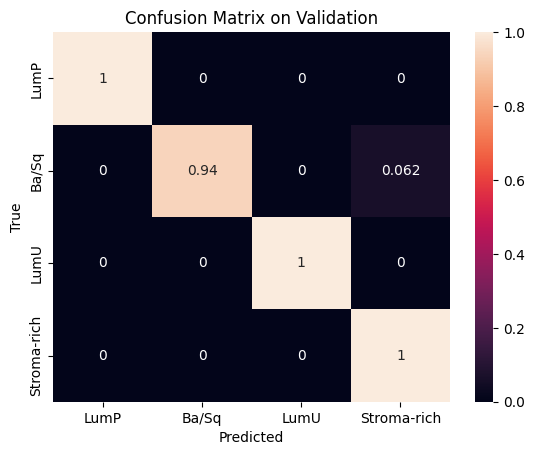

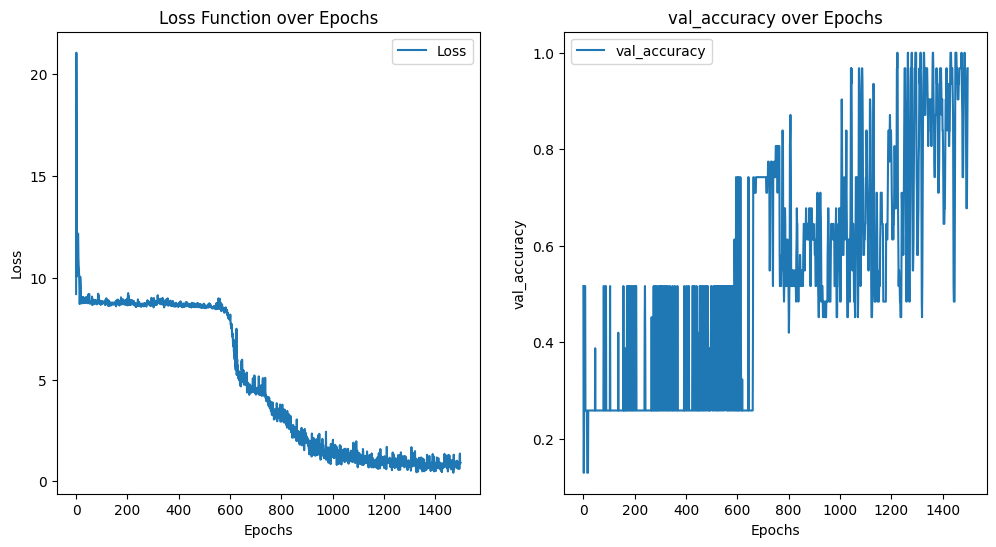

Fold: 2, Epoch: 001, Loss: 9.1995, Train_acc 0.4048, Val_acc 0.4516
Fold: 2, Epoch: 002, Loss: 21.0611, Train_acc 0.1190, Val_acc 0.1935
Fold: 2, Epoch: 003, Loss: 17.1621, Train_acc 0.1190, Val_acc 0.1935
Fold: 2, Epoch: 004, Loss: 10.0641, Train_acc 0.3360, Val_acc 0.2258
Fold: 2, Epoch: 005, Loss: 11.7918, Train_acc 0.3360, Val_acc 0.2258
Fold: 2, Epoch: 006, Loss: 11.7066, Train_acc 0.3360, Val_acc 0.2258
Fold: 2, Epoch: 007, Loss: 11.1184, Train_acc 0.4048, Val_acc 0.4516
Fold: 2, Epoch: 008, Loss: 12.1703, Train_acc 0.4048, Val_acc 0.4516
Fold: 2, Epoch: 009, Loss: 12.1697, Train_acc 0.3360, Val_acc 0.2258
Fold: 2, Epoch: 010, Loss: 11.0016, Train_acc 0.3360, Val_acc 0.2258
Fold: 2, Epoch: 011, Loss: 10.6071, Train_acc 0.3360, Val_acc 0.2258
Fold: 2, Epoch: 012, Loss: 10.4303, Train_acc 0.3360, Val_acc 0.2258
Fold: 2, Epoch: 013, Loss: 9.9620, Train_acc 0.3360, Val_acc 0.2258
Fold: 2, Epoch: 014, Loss: 9.2695, Train_acc 0.3360, Val_acc 0.2258
Fold: 2, Epoch: 015, Loss: 8.7085, Tr

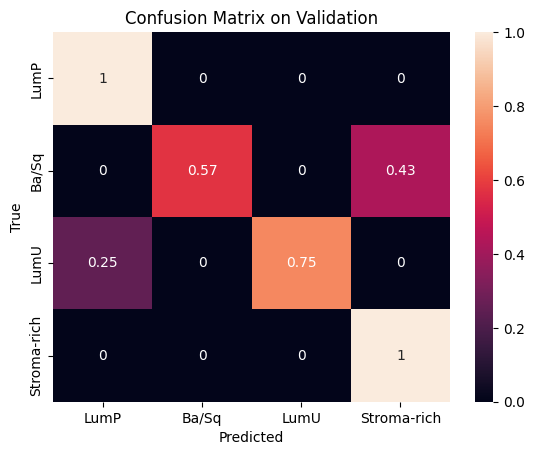

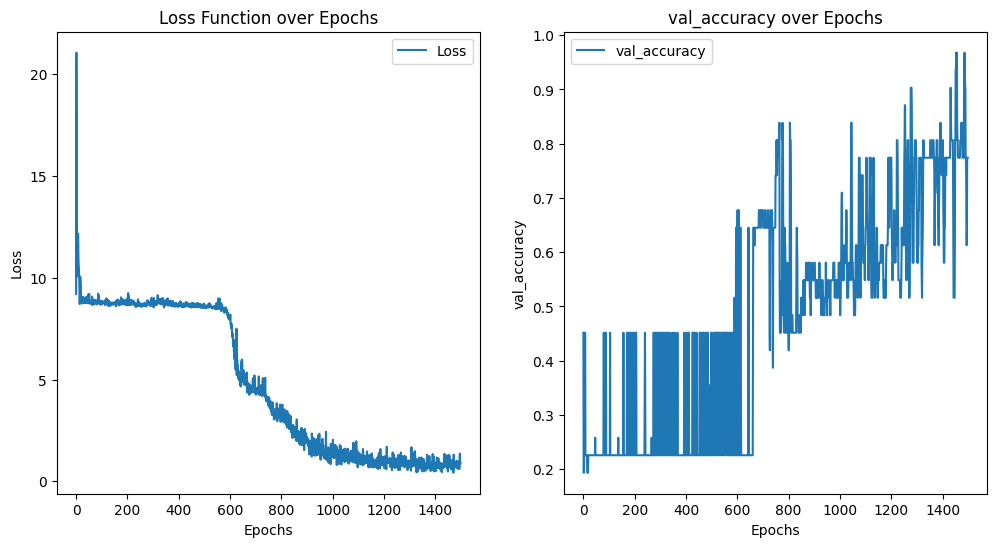

Fold: 3, Epoch: 001, Loss: 9.1995, Train_acc 0.4048, Val_acc 0.3333
Fold: 3, Epoch: 002, Loss: 21.0611, Train_acc 0.1190, Val_acc 0.1000
Fold: 3, Epoch: 003, Loss: 17.1621, Train_acc 0.1190, Val_acc 0.1000
Fold: 3, Epoch: 004, Loss: 10.0641, Train_acc 0.3360, Val_acc 0.4000
Fold: 3, Epoch: 005, Loss: 11.7918, Train_acc 0.3360, Val_acc 0.4000
Fold: 3, Epoch: 006, Loss: 11.7066, Train_acc 0.3360, Val_acc 0.4000
Fold: 3, Epoch: 007, Loss: 11.1184, Train_acc 0.4048, Val_acc 0.3333
Fold: 3, Epoch: 008, Loss: 12.1703, Train_acc 0.4048, Val_acc 0.3333
Fold: 3, Epoch: 009, Loss: 12.1697, Train_acc 0.3360, Val_acc 0.4000
Fold: 3, Epoch: 010, Loss: 11.0016, Train_acc 0.3360, Val_acc 0.4000
Fold: 3, Epoch: 011, Loss: 10.6071, Train_acc 0.3360, Val_acc 0.4000
Fold: 3, Epoch: 012, Loss: 10.4303, Train_acc 0.3360, Val_acc 0.4000
Fold: 3, Epoch: 013, Loss: 9.9620, Train_acc 0.3360, Val_acc 0.4000
Fold: 3, Epoch: 014, Loss: 9.2695, Train_acc 0.3360, Val_acc 0.4000
Fold: 3, Epoch: 015, Loss: 8.7085, Tr

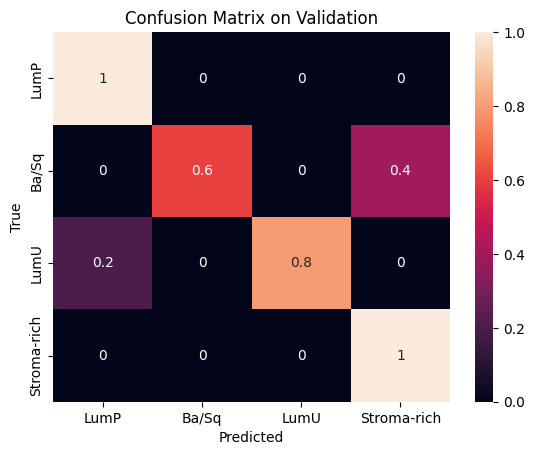

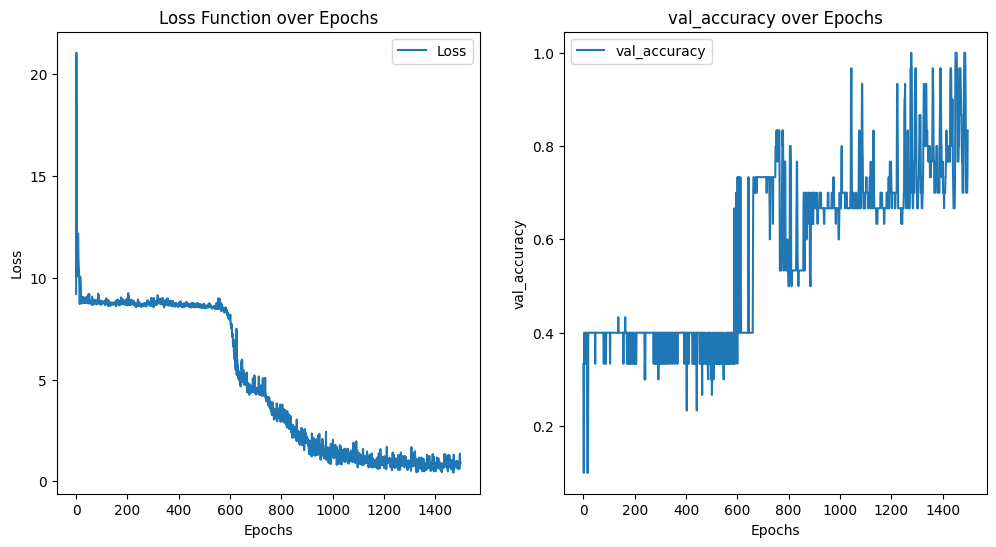

Fold: 4, Epoch: 001, Loss: 9.1995, Train_acc 0.4048, Val_acc 0.4333
Fold: 4, Epoch: 002, Loss: 21.0611, Train_acc 0.1190, Val_acc 0.0000
Fold: 4, Epoch: 003, Loss: 17.1621, Train_acc 0.1190, Val_acc 0.0000
Fold: 4, Epoch: 004, Loss: 10.0641, Train_acc 0.3360, Val_acc 0.4667
Fold: 4, Epoch: 005, Loss: 11.7918, Train_acc 0.3360, Val_acc 0.4667
Fold: 4, Epoch: 006, Loss: 11.7066, Train_acc 0.3360, Val_acc 0.4667
Fold: 4, Epoch: 007, Loss: 11.1184, Train_acc 0.4048, Val_acc 0.4333
Fold: 4, Epoch: 008, Loss: 12.1703, Train_acc 0.4048, Val_acc 0.4333
Fold: 4, Epoch: 009, Loss: 12.1697, Train_acc 0.3360, Val_acc 0.4667
Fold: 4, Epoch: 010, Loss: 11.0016, Train_acc 0.3360, Val_acc 0.4667
Fold: 4, Epoch: 011, Loss: 10.6071, Train_acc 0.3360, Val_acc 0.4667
Fold: 4, Epoch: 012, Loss: 10.4303, Train_acc 0.3360, Val_acc 0.4667
Fold: 4, Epoch: 013, Loss: 9.9620, Train_acc 0.3360, Val_acc 0.4667
Fold: 4, Epoch: 014, Loss: 9.2695, Train_acc 0.3360, Val_acc 0.4667
Fold: 4, Epoch: 015, Loss: 8.7085, Tr

/tmp/ipykernel_90266/4196756951.py:55: RuntimeWarning: invalid value encountered in divide
  conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]


ValueError: Shape of passed values is (4, 4), indices imply (3, 3)

In [11]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
import seaborn as sn

def cross_validation(data, k_folds, hidden_channels, heads, num_epochs=1000):
    skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=1234)
    all_val_acc = []

    val_acc_best = 0
    data_X_for_Val, data_Y_for_val  = distinction(data)

    # Create folds for building a more robust model
    for fold, (_, val_index) in enumerate(skf.split(data_X_for_Val, data_Y_for_val)):

        # Define masks
        train_index = [i for i in range(data.num_nodes)]
        data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
        data.train_mask[train_index] = True
        
        data.val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
        data.val_mask[val_index] = True
        
        train_classes, _ = count_classes_weights(data.y[data.train_mask])
        val_classes, _ = count_classes_weights(data.y[data.val_mask])

        # Initialize model, optimizer, and loss function
        model = GATv2(hidden_channels=hidden_channels, heads=heads, data=data)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

        lost_function_compil = []
        all_val_acc_plot = []

        # Training loop
        for epoch in range(1, num_epochs):
            loss, model = train(model, data, optimizer)
            train_acc, _ = test (model, data, data.train_mask)
            val_acc, _ = test(model, data, data.val_mask)
            lost_function_compil.append(loss.detach().tolist())
            all_val_acc_plot.append(val_acc)
            print(f'Fold: {fold + 1}, Epoch: {epoch:03d}, Loss: {loss:.4f}, Train_acc {train_acc:.4f}, Val_acc {val_acc:.4f}')

        # Evaluate on validation set
        val_acc, y_pred = test(model, data, data.val_mask)
        y_true = data.y[data.val_mask]

        # Store results
        all_val_acc.append(val_acc)
        conf_matrix = confusion_matrix(y_true.cpu().tolist(), y_pred.cpu().tolist())
        
        # Setting the best model through the folds
        if val_acc > val_acc_best:
            best_model = model

        # Plot confusion matrix
        conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
        df_cm = pd.DataFrame(conf_matrix_normalized, index=val_classes, columns=val_classes)  
        sn.heatmap(df_cm, annot=True)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix on Validation')
        plt.show()

        # Plot the loss function and the accuracy improvement
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

        ax1.plot(range(len(lost_function_compil)), lost_function_compil, label='Loss')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Loss')
        ax1.set_title('Loss Function over Epochs')
        ax1.legend()

        ax2.plot(range(len(all_val_acc_plot)), all_val_acc_plot, label='val_accuracy')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('val_accuracy')
        ax2.set_title('val_accuracy over Epochs')
        ax2.legend()

        plt.show()

    # Calculate and print overall metrics
    mean_val_acc = np.mean(all_val_acc)
    std_val_acc = np.std(all_val_acc)
    print(f'Mean Validation Accuracy: {mean_val_acc:.4f}, Std Validation Accuracy: {std_val_acc:.4f}')

    return best_model

# Training phase
best_model = cross_validation(train_val_data, k_folds=10, hidden_channels=20, heads=8, num_epochs=1500)

In [12]:
# Testing phase

test_mask = torch.ones(test_data.num_nodes, dtype=torch.bool)
test_acc, y_pred = test(best_model, test_data, test_mask)
y_true = test_data.y[test_mask]


# Plot the confusion matrix
conf_matrix = confusion_matrix(y_true.cpu().tolist(), y_pred.cpu().tolist())
print(f'Test accuracy: {test_acc:.4f}')
classes = ('LumP', 'Ba/Sq', 'LumU', 'Stroma-rich')
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(conf_matrix_normalized, index=classes, columns=classes)  
sn.heatmap(df_cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix on Test')
plt.show()

NameError: name 'best_model' is not defined